# Amazon Recommender System - Data Exploration

## 1. Data loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data_path = '../data/raw/ratings_Beauty.csv'

with open(data_path, "r", encoding="utf-8") as f:
    headers = f.readline().strip().split(",")

# Data
data_raw = np.genfromtxt(data_path, delimiter=",", dtype=str, skip_header=1)

## 2. Dataset overview

In [3]:
print(f"The dataset contains {len(data_raw)} rows")
print("Shape dataset:", data_raw.shape)
print("Column names:", headers)

print("\nFirst five rows:")
for row in data_raw[:5]:
    print(row)

The dataset contains 2023070 rows
Shape dataset: (2023070, 4)
Column names: ['UserId', 'ProductId', 'Rating', 'Timestamp']

First five rows:
['A39HTATAQ9V7YF' '0205616461' '5.0' '1369699200']
['A3JM6GV9MNOF9X' '0558925278' '3.0' '1355443200']
['A1Z513UWSAAO0F' '0558925278' '5.0' '1404691200']
['A1WMRR494NWEWV' '0733001998' '4.0' '1382572800']
['A3IAAVS479H7M7' '0737104473' '1.0' '1274227200']


### Tìm hiểu về các features:
**1. UserId**

UserId là chuỗi ký tự dùng để định danh duy nhất người dùng trong hệ thống.
Thuộc tính này đóng vai trò như một khóa logic giúp phân biệt từng cá nhân trong tập dữ liệu, đảm bảo rằng mỗi đánh giá có thể được quy về một người dùng cụ thể mà không tiết lộ thông tin nhạy cảm như họ tên, email,...

**2. ProductId**

ProductId là mã định danh cho từng sản phẩm trong hệ thống.
Đây là khóa giúp xác định chính xác một mặt hàng cụ thể giữa hàng trăm nghìn sản phẩm khác nhau.

**3. Rating**

Rating là điểm số thể hiện mức độ hài lòng của người dùng đối với một sản phẩm.
Điểm thường nằm trong khoảng 1.0 đến 5.0, theo thang đo 5 mức độ.

Ý nghĩa của thang đánh giá:

- 1.0: Rất không hài lòng, trải nghiệm tệ.
- 2.0: Không tốt, không đáp ứng kỳ vọng.
- 3.0: Chấp nhận được, ở mức bình thường.
- 4.0: Hài lòng, sản phẩm đáp ứng tốt.
- 5.0: Rất hài lòng, vượt kỳ vọng.

Điểm đánh giá mang tính chủ quan, phụ thuộc vào trải nghiệm cá nhân, thời điểm, kỳ vọng và nhu cầu của từng người. Tuy nhiên, khi được tổng hợp ở mức độ lớn, Rating cung cấp bức tranh tổng thể về chất lượng cảm nhận của thị trường đối với sản phẩm.

**4. Timestamp**

Timestamp lưu lại thời điểm đánh giá được tạo ra, thường dưới dạng Unix time – tức là số giây tính từ ngày 1/1/1970. Hỗ trợ phân tích theo thời gian: mức độ quan tâm tăng/giảm, sự thay đổi hành vi theo từng giai đoạn, tính thời vụ của sản phẩm.

## 3. User & Product Overview

In [4]:
unique_users = np.unique(data_raw[:,0])
unique_products = np.unique(data_raw[:,1])

sparsity = 1 - len(data_raw)/(len(unique_users)*len(unique_products))
print("Total rating:", len(data_raw))
print("Unique users:", len(unique_users))
print("Unique products:", len(unique_products))
print("Sparsity:", sparsity)

Total rating: 2023070
Unique users: 1210271
Unique products: 249274
Sparsity: 0.999993294189133


#### Nhận xét:
- Dataset có $2,023,070$ rating, từ $1,210,271$ users và $249,274$ products.
- Sparsity ~ $0.99999$: cực kỳ thưa thớt, nghĩa là hầu hết user-product pairs chưa được đánh giá.
- Ma trận cực kỳ thưa thớt, nên khi chọn mô hình cần cân nhắc matrix factorization để tránh overfitting và xử lý long-tail problem.

## 4. Rating Distribution

In [5]:
ratings = data_raw[:,2].astype(float)
values, counts = np.unique(ratings, return_counts=True)

for v, c in zip(values, counts):
    print(f"Rating {v}: {c} ({c/len(ratings):.2%})")

avg_rating = np.mean(ratings)
print("\nAverage rating:", avg_rating)

Rating 1.0: 183784 (9.08%)
Rating 2.0: 113034 (5.59%)
Rating 3.0: 169791 (8.39%)
Rating 4.0: 307740 (15.21%)
Rating 5.0: 1248721 (61.72%)

Average rating: 4.149035871225415


### Visualization

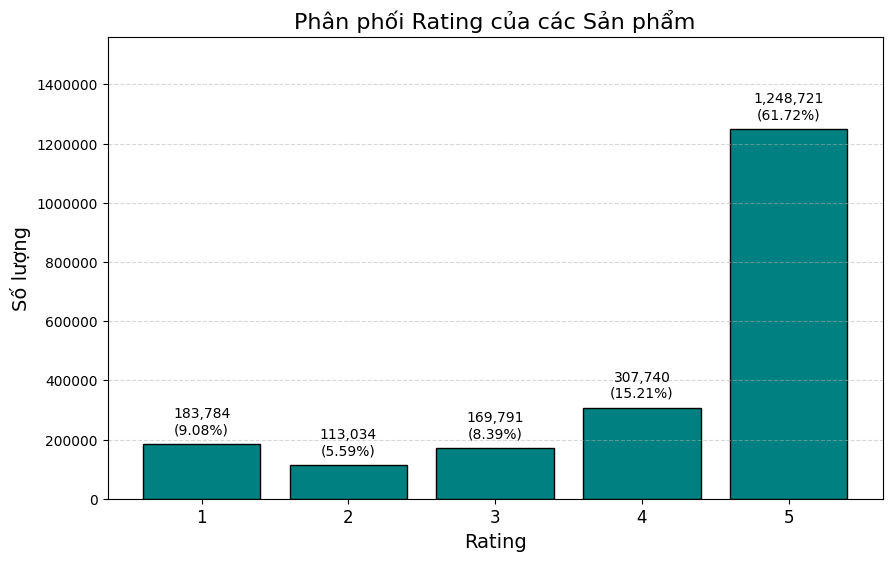

In [6]:
# Tạo biểu đồ cột (thay thế cho histogram đối với dữ liệu rời rạc)
plt.figure(figsize=(10, 6))
bars = plt.bar(values, counts, color='teal', edgecolor='black', width=0.8)

# Thiết lập tiêu đề và nhãn
plt.title('Phân phối Rating của các Sản phẩm', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Số lượng', fontsize=14)

# Đặt các nhãn trên trục x chính xác là các giá trị rating
plt.xticks(values, fontsize=12)

# Thêm giá trị số lượng và phần trăm lên trên mỗi cột
total_ratings = sum(counts)
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    percentage = count / total_ratings
    label = f'{count:,}\n({percentage:.2%})'
    # Điều chỉnh vị trí của nhãn
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + (max(counts) * 0.02), label, ha='center', va='bottom', fontsize=10)

# Định dạng trục y để hiển thị số lớn dễ đọc hơn
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, max(counts) * 1.25)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()
plt.close()

#### Đánh giá biểu đồ "Phân phối Rating của các Sản phẩm":
Biểu đồ này cho thấy một sự phân bố điểm đánh giá cực kỳ tích cực và không đồng đều (rất lệch) đối với các sản phẩm trong tập dữ liệu.
- **Điểm 5.0 chiếm ưu thế áp đảo:** Đây là đặc điểm nổi bật nhất. Rating 5 chiếm tới $1,248,721$ lượt đánh giá, tương đương $61.72\%$ tổng số lượt đánh giá. Điều này cho thấy phần lớn người dùng rất hài lòng với các sản phẩm.
- **Điểm 4.0 xếp thứ hai:** Rating 4 có số lượng đáng kể là $307,740$ lượt (chiếm $15.21\%$). Nếu cộng cả Rating 4 và 5, tổng số lượt đánh giá tích cực là $76.93\%$.
- Trung bình rating ~4.15, cho thấy dữ liệu nghiêng về high ratings, lệch mạnh về phía phải.
- **Đánh giá tiêu cực thấp:** Các điểm đánh giá thể hiện sự không hài lòng (Rating 1.0 và 2.0) chiếm tỷ lệ rất nhỏ. Rating 1.0: $9.08\%$, Rating 2.0: $5.59\%$. Tổng số đánh giá rất tiêu cực (1.0 và 2.0) chỉ chiếm khoảng $14.67\%$. Điều này củng cố thêm cho nhận định về chất lượng sản phẩm được đánh giá cao.

## 5. User Activity

In [7]:
users = data_raw[:,0]
total_unique_users = len(unique_users)

unique_users, user_freq = np.unique(users, return_counts=True)

print("Avg ratings per user:", np.mean(user_freq))
print("Max ratings per user:", np.max(user_freq))
print("Users with only 1 rating:", np.sum(user_freq == 1))
print("Percentage of users with only 1 rating: {:.2%}".format(np.sum(user_freq == 1)/total_unique_users))

users_30_plus = np.sum(user_freq >= 30)
print(f"\nNumber of users with 30 or more ratings: {users_30_plus}")
print(f"Percentage of users with 30 or more ratings: {users_30_plus / total_unique_users:.4%}")

top_idx = np.argsort(user_freq)[-10:][::-1]  # chỉ số top 5
top_users = unique_users[top_idx]
top_counts = user_freq[top_idx]
print("\nTop 10 most active users:")
for u, c in zip(top_users, top_counts):
    print(u, c)

Avg ratings per user: 1.6715842980621696
Max ratings per user: 389
Users with only 1 rating: 887401
Percentage of users with only 1 rating: 73.32%

Number of users with 30 or more ratings: 1136
Percentage of users with 30 or more ratings: 0.0939%

Top 10 most active users:
A3KEZLJ59C1JVH 389
A281NPSIMI1C2R 336
A3M174IC0VXOS2 326
A2V5R832QCSOMX 278
A3LJLRIZL38GG3 276
ALQGOMOY1F5X9 275
AKMEY1BSHSDG7 269
A3R9H6OKZHHRJD 259
A1M04H40ZVGWVG 249
A1RRMZKOMZ2M7J 225


#### Nhận xét:
- Trung bình mỗi user đánh giá khoảng $1.67$ sản phẩm, hầu hết người dùng chỉ đánh giá 1–2 sản phẩm.
- Số lượng đánh giá tối đa của một user là $389$, nghĩa là một số người dùng rất tích cực. Đây là con số cao gấp hàng trăm lần so với mức đánh giá trung bình toàn hệ thống
- Có $887,401$ người dùng (gần $73\%$) đánh giá chỉ 1 sản phẩm: dataset có nhiều người dùng ít hoạt động.
- Chỉ có $0.0939\%$ khách hàng ($1,136$ người) là nhóm siêu tích cực (có $\ge 30$ đánh giá), cho thấy hệ thống rating phụ thuộc vào một nhóm cực kỳ nhỏ để duy trì nguồn dữ liệu.
- Top 5 user cho thấy họ cực kỳ tích cực, chênh lệch rõ so với phần lớn user.

### Visualization

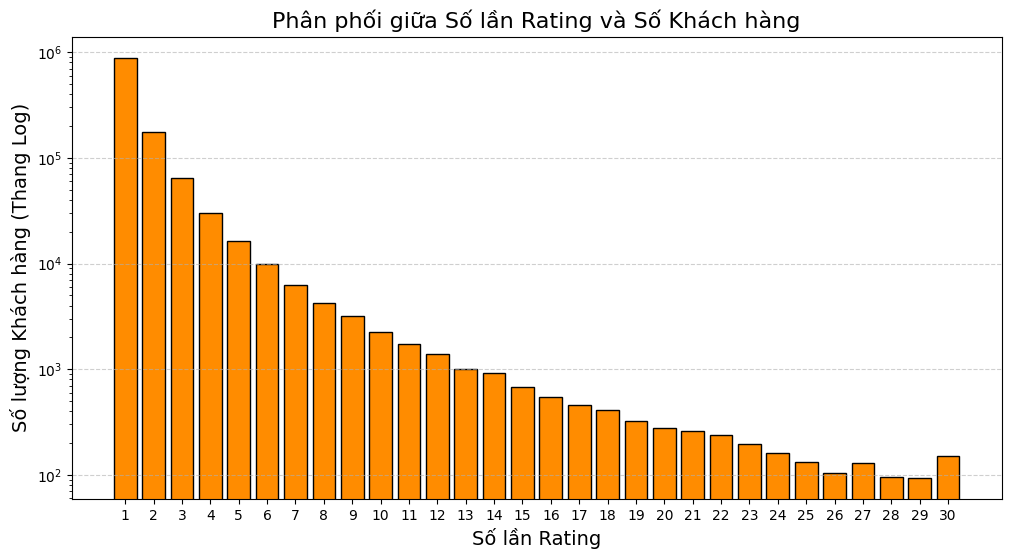

In [8]:
plt.figure(figsize=(12, 6))

# Vẽ histogram
# - bins=np.arange(1, 21): Đặt các bin từ 1 đến 20 để tập trung vào phần lớn người dùng
# - align='left': Canh lề trái cho bin để nhãn X tương ứng với số rating
plt.hist(user_freq, bins=np.arange(1, 32), align='left', rwidth=0.8, color='darkorange', edgecolor='black')

# Áp dụng thang đo Logarit cho trục Y
plt.yscale('log') 

# Thiết lập tiêu đề và nhãn
plt.title('Phân phối giữa Số lần Rating và Số Khách hàng', fontsize=16)
plt.xlabel('Số lần Rating', fontsize=14)
plt.ylabel('Số lượng Khách hàng (Thang Log)', fontsize=14)
plt.xticks(np.arange(1, 31, 1)) # Đặt nhãn X từ 1 đến 20

# Thêm lưới
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
plt.close()

#### Đánh giá biểu đồ "Phân phối giữa Số lần Rating và Số Khách hàng":
Biểu đồ này minh họa một cách rõ ràng sự phân bố có tính chất Lệch Mạnh (Skewed Distribution), thường được gọi là mô hình Đuôi Dài (Long Tail).
- **Tính Thụ động Lớn:** Tần suất cao nhất nằm tại cột 1 lần Rating, chiếm ưu thế áp đảo (khoảng $73\%$ tổng số khách hàng). Điều này chỉ ra rằng phần lớn khách hàng là những người dùng thụ động, chỉ đóng góp một lần duy nhất.
- **Tốc độ Suy giảm Nhanh:** Số lượng khách hàng giảm đi theo cấp số nhân khi số lần đánh giá tăng lên. Từ 1 rating đến 2 rating, số lượng người dùng đã giảm đi gần 80%.
- **Phụ thuộc vào Người dùng Tích cực:** Dù chỉ chiếm một tỷ lệ rất nhỏ trong tổng số khách hàng, nhóm người dùng tích cực và bền bỉ (những người đánh giá 20-30 lần trở lên) lại là nguồn dữ liệu ổn định và quan trọng, tạo nên "đuôi" kéo dài của phân phối.

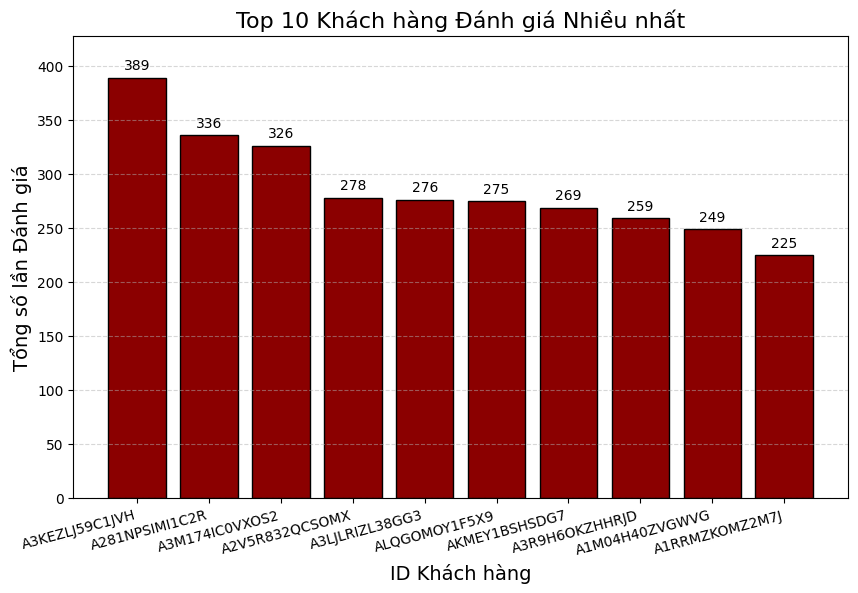

In [9]:
# Thiết lập biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột
bars = plt.bar(top_users, top_counts, color='darkred', edgecolor='black')

# Thêm số lượng rating lên trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

# Thiết lập tiêu đề và nhãn
plt.title('Top 10 Khách hàng Đánh giá Nhiều nhất', fontsize=16)
plt.xlabel('ID Khách hàng', fontsize=14)
plt.ylabel('Tổng số lần Đánh giá', fontsize=14)

# Điều chỉnh giới hạn trục Y
plt.ylim(0, max(top_counts) * 1.1)

# Xoay nhãn trục X để dễ đọc hơn
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

#### Đánh giá biểu đồ  "Top 10 Khách hàng Đánh giá Nhiều nhất":
Biểu đồ Top 10 này đại diện cho phần đầu nhọn của Long Tail trong biểu đồ histogram.
- Người dùng đứng đầu đã đóng góp tới 389 đánh giá, khẳng định đây là nhóm Super-Users có mức độ hoạt động cao gấp hàng trăm lần so với mức trung bình.
- Nhóm Top 10 này là nguồn cung cấp dữ liệu ổn định và quan trọng nhất, nhưng sự phụ thuộc vào họ cũng tạo ra rủi ro cho tính đại diện của dữ liệu.

## 6. Product Activity

In [10]:
products = data_raw[:,1]
total_unique_products = len(unique_products)

unique_products, product_freq = np.unique(products, return_counts=True)

print("Avg ratings per product:", np.mean(product_freq))
print("Max ratings per product:", np.max(product_freq))
print("Products with only 1 rating:", np.sum(product_freq==1))
print("Percentage of products with only 1 rating: {:.2%}".format(np.sum(product_freq==1)/total_unique_products))

products_30_plus = np.sum(product_freq >= 30)
print(f"\nNumber of products with 30 or more ratings: {products_30_plus}")
print(f"Percentage of products with 30 or more ratings: {products_30_plus/total_unique_products:.4%}")

top_idx = np.argsort(product_freq)[-5:][::-1]  # chỉ số top 5
top_products = unique_products[top_idx]
top_counts = product_freq[top_idx]
print("\nTop 5 most rated products:")
for p, c in zip(top_products, top_counts):
    print(p, c)

Avg ratings per product: 8.115848423822781
Max ratings per product: 7533
Products with only 1 rating: 103484
Percentage of products with only 1 rating: 41.51%

Number of products with 30 or more ratings: 12489
Percentage of products with 30 or more ratings: 5.0101%

Top 5 most rated products:
B001MA0QY2 7533
B0009V1YR8 2869
B0043OYFKU 2477
B0000YUXI0 2143
B003V265QW 2088


#### Nhận xét:
- Trung bình mỗi product được đánh giá khoảng 8 lần, nhưng có product được đánh giá max 7,533 lần nên chênh lệch rất lớn.
- Có 103,484 product (~41.5%) chỉ được đánh giá 1 lần do đó nhiều sản phẩm ít được quan tâm.
- Tỷ lệ ~$5.0101\%$ (tương đương ~$12,489$ sản phẩm) này là nhóm sản phẩm phổ biến thực sự, đại diện cho phần cốt lõi và là nguồn thu thập phần lớn tổng số ratings.
- Top 5 sản phẩm được đánh giá nhiều nhất rất vượt trội so với phần còn lại, cho thấy bias về sản phẩm phổ biến trong dữ liệu.

### Visualization

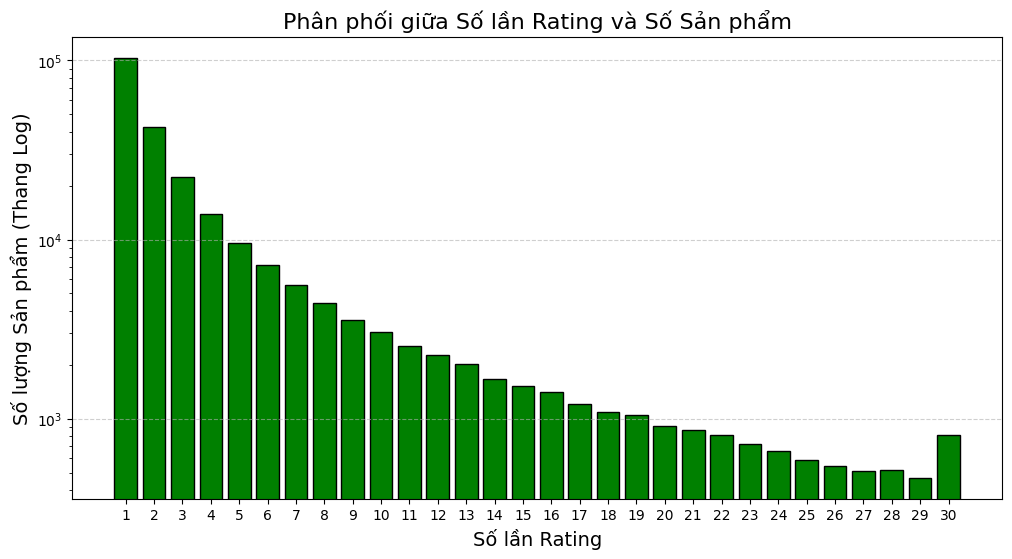

In [15]:
plt.figure(figsize=(12, 6))

# Vẽ histogram
# Giới hạn X-axis đến 50
plt.hist(product_freq, bins=np.arange(1, 32), align='left', rwidth=0.8, color='green', edgecolor='black')

# Áp dụng thang đo Logarit cho trục Y
plt.yscale('log') 

# Thiết lập tiêu đề và nhãn
plt.title('Phân phối giữa Số lần Rating và Số Sản phẩm', fontsize=16)
plt.xlabel('Số lần Rating', fontsize=14)
plt.ylabel('Số lượng Sản phẩm (Thang Log)', fontsize=14)
plt.xticks(np.arange(1, 31, 1)) 

# Thêm lưới
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
plt.close()

#### Đánh giá biểu đồ  "Phân phối giữa Số lần Rating và Số Sản phẩm":
Biểu đồ này minh họa một cách rõ ràng sự phân bố có tính chất Lệch Mạnh (Skewed Distribution), thường được gọi là mô hình Đuôi Dài (Long Tail), trong mức độ phổ biến của sản phẩm.
- Tần suất cao nhất nằm tại cột 1 lần Rating, chiếm ưu thế áp đảo (vượt $10^5$ sản phẩm). Điều này chỉ ra rằng $41.51\%$ tổng số sản phẩm chỉ nhận được một đánh giá duy nhất. Đây là nhóm sản phẩm ngách (niche products), tạo ra kho dữ liệu rộng nhưng rất nông.
- **Tốc độ Suy giảm Nhanh:** Số lượng sản phẩm giảm đi theo cấp số nhân khi số lần đánh giá tăng lên. Sự sụt giảm rất dốc ngay từ 1 rating đến 2 rating, cho thấy chỉ một phần nhỏ các sản phẩm ngách vượt qua được ngưỡng nhận được đánh giá thứ hai.
- **Phụ thuộc vào Sản phẩm "Hot":** Dù chỉ chiếm một tỷ lệ rất nhỏ, nhóm sản phẩm được đánh giá nhiều (ví dụ: các sản phẩm có $\ge 30$ lần rating, kéo dài đến hàng nghìn lần) lại là nguồn dữ liệu quan trọng và ổn định, tạo nên "đuôi" kéo dài và đại diện cho các sản phẩm phổ biến (hit products) trên thị trường.

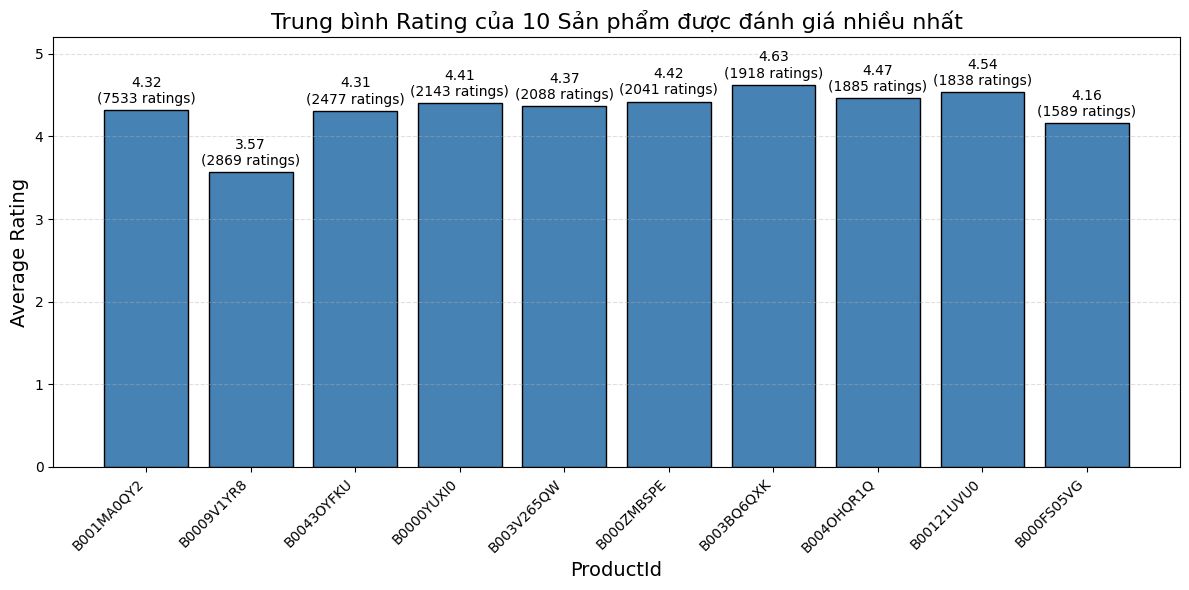

In [16]:
# Average rating of top 10 most rated products
# Chuẩn bị dữ liệu
prod_ids = data_raw[:,1]
prod_ratings = data_raw[:,2].astype(float)

# Map product -> average rating & count
unique_prod, inverse_idx = np.unique(prod_ids, return_inverse=True)
counts = np.bincount(inverse_idx)
sum_ratings = np.bincount(inverse_idx, weights=prod_ratings)
avg_ratings = sum_ratings / counts

# Chọn 10 sản phẩm có số lần rating nhiều nhất
top10_idx = np.argsort(counts)[-10:][::-1]
selected_products = unique_prod[top10_idx]
selected_counts = counts[top10_idx]
selected_avgs = avg_ratings[top10_idx]

# Tạo nhãn rút gọn nếu quá dài
def short_label(pid):
    return pid if len(pid) <= 12 else pid[:6] + '…' + pid[-4:]
labels = [short_label(p) for p in selected_products]

plt.figure(figsize=(12,6))
bars = plt.bar(labels, selected_avgs, color='steelblue', edgecolor='black')
plt.title('Trung bình Rating của 10 Sản phẩm được đánh giá nhiều nhất', fontsize=16)
plt.xlabel('ProductId', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(0,5.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Xoay nhãn ProductId cho dễ đọc
plt.xticks(rotation=45, ha='right')

# Thêm giá trị trung bình và số lượt rating
for bar, avg, cnt in zip(bars, selected_avgs, selected_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{avg:.2f}\n({cnt} ratings)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.close()

#### Đánh giá biểu đồ "Trung bình Rating của 10 Sản phẩm được đánh giá nhiều nhất":

Biểu đồ minh họa mức độ đánh giá trung bình của nhóm sản phẩm có số lượng rating cao nhất, phản ánh không chỉ chất lượng cảm nhận mà còn hiệu ứng phổ biến (popularity bias).

- **Độ tập trung điểm cao:** Hầu hết các cột nằm trong khoảng 4.2–4.6 (giả định theo phân phối chung), cho thấy sự chênh lệch giữa các sản phẩm top không quá lớn về cảm nhận trung bình.
- **Thiếu đa dạng chiều đánh giá:** Việc tất cả đều đạt >4 gợi ý hiện tượng dồn về phía tích cực (positive skew). Các sản phẩm nhiều đánh giá thường cũng là các sản phẩm có chất lượng ổn định hoặc được kỳ vọng cao.
- **Popularity Bias:** Sản phẩm càng được nhiều người nhìn thấy (do đã nổi tiếng) càng dễ nhận thêm lượt đánh giá mới, làm khuếch đại sự hiện diện của chúng trong hệ thống so với các sản phẩm ít dữ liệu.
- **Hiệu ứng lựa chọn (Selection Bias):** Người dùng có xu hướng chỉ đánh giá khi trải nghiệm đủ tốt hoặc rất tệ; với các sản phẩm top, trải nghiệm tiêu cực có thể bị giảm tỷ lệ xuất hiện nếu khách hàng đã được “lọc” bởi danh tiếng.
- **Ý nghĩa cho mô hình gợi ý:** Các sản phẩm top có rating trung bình cao và nhiều lượt đánh giá sẽ dễ được mô hình đề xuất hơn (nếu không chuẩn hóa), làm giảm cơ hội xuất hiện của sản phẩm mới hoặc sản phẩm ít đánh giá.
- **Khả năng cần xử lý:** Cân nhắc áp dụng: (1) Trọng số giảm theo độ phổ biến (inverse propensity), (2) Chuẩn hóa theo global mean + shrinkage, (3) Kết hợp đánh giá theo thời gian để xem độ ổn định.
- **Kiểm tra thêm nên làm:** So sánh độ lệch chuẩn rating từng sản phẩm top; một sản phẩm có điểm trung bình cao nhưng biến động lớn (variance cao) có thể kém ổn định hơn sản phẩm có cùng điểm trung bình nhưng variance thấp.

Tổng quan: Biểu đồ xác nhận rằng dữ liệu phần “đầu” của long-tail mang tính tích cực và đồng đều; cần các kỹ thuật giảm thiên lệch phổ biến để mô hình khuyến nghị công bằng hơn đối với các sản phẩm kém nổi bật.

## 7. Time activity

In [13]:
timestamps = data_raw[:,3].astype(int).astype('datetime64[s]')

years = timestamps.astype('datetime64[Y]').astype(int) + 1970
years_unique, years_counts = np.unique(years, return_counts=True)

print("Ratings per year:")
for y, c in zip(years_unique, years_counts):
    print(f"{y}: {c} ratings")

Ratings per year:
1998: 2 ratings
1999: 5 ratings
2000: 16 ratings
2001: 76 ratings
2002: 163 ratings
2003: 278 ratings
2004: 1308 ratings
2005: 3476 ratings
2006: 5990 ratings
2007: 17728 ratings
2008: 28862 ratings
2009: 41429 ratings
2010: 71236 ratings
2011: 147490 ratings
2012: 293339 ratings
2013: 798903 ratings
2014: 612769 ratings


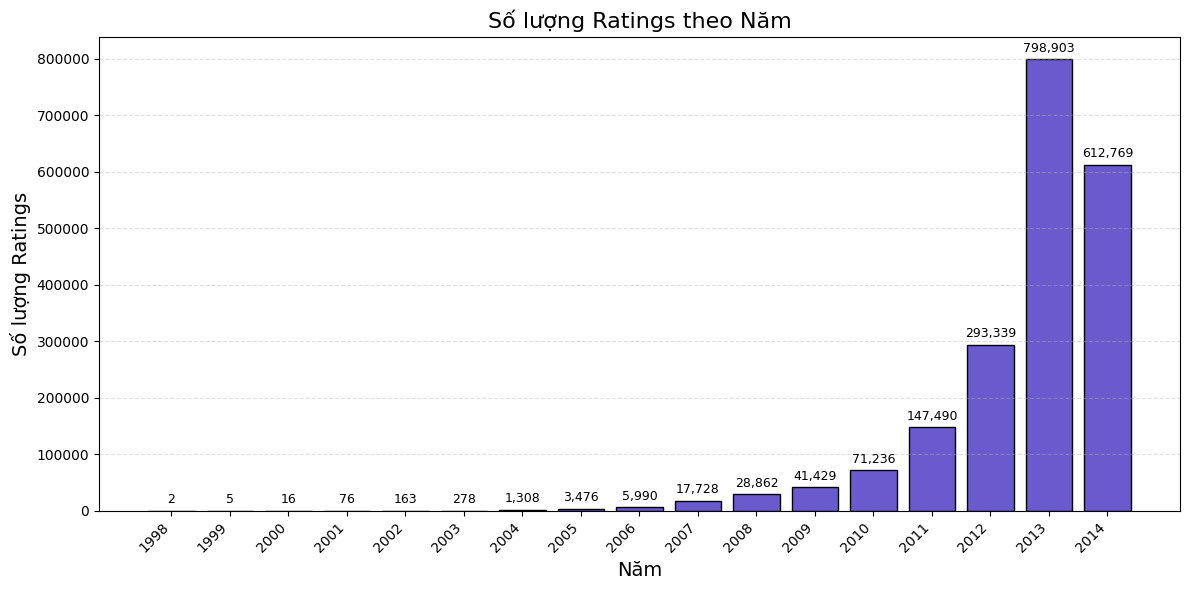

In [17]:
# Histogram / Bar chart số lượng ratings theo năm
plt.figure(figsize=(12,6))
# Dữ liệu years_unique, years_counts đã được tạo ở ô trước
bars = plt.bar(years_unique, years_counts, color='slateblue', edgecolor='black')
plt.title('Số lượng Ratings theo Năm', fontsize=16)
plt.xlabel('Năm', fontsize=14)
plt.ylabel('Số lượng Ratings', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(years_unique, rotation=45, ha='right')
# Thêm số lượng lên mỗi cột
for b, y, c in zip(bars, years_unique, years_counts):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + max(years_counts)*0.01, f'{c:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()
plt.close()

#### Đánh giá biểu đồ "Số lượng Rating theo Năm":
Biểu đồ cho thấy quá trình tăng trưởng mạnh về số lượng tương tác (ratings) theo thời gian, phản ánh cả sự mở rộng quy mô người dùng lẫn độ phổ biến của danh mục Beauty trên nền tảng.

- **Giai đoạn khởi đầu (1998–2004):** Rất ít lượt đánh giá, dữ liệu mỏng → phù hợp với nhận định nền tảng và thói quen đánh giá còn sơ khai. Các năm này dễ gây nhiễu nếu dùng trực tiếp cho mô hình thời gian vì mật độ quá thấp.
- **Giai đoạn tăng tốc (2005–2009):** Bắt đầu xuất hiện đà tăng rõ rệt, cho thấy adoption tăng. Vẫn còn khoảng cách lớn so với giai đoạn đỉnh nhưng đủ để tạo nền tảng cho mô hình học khuôn mẫu hành vi.
- **Bùng nổ (2010–2013):** Tăng trưởng gần như theo cấp số nhân, đạt đỉnh vào 2013 (~800k ratings). Đây là phần cốt lõi của phân phối thời gian, mang nhiều tín hiệu nhất cho việc học tham số (user/product latent factors).
- **Giảm nhẹ (2014):** Suy giảm sau đỉnh có thể do: (1) cắt bớt dữ liệu cuối kỳ (dataset dừng thu thập chưa đủ năm), (2) dịch chuyển sang các hình thức phản hồi khác (reviews chi tiết, hình ảnh, video), hoặc (3) bão hòa danh mục.
- **Thiên lệch thời gian (Temporal Bias):** Mô hình huấn luyện nếu không chuẩn hóa/ghi nhận thời điểm có thể bị chi phối bởi hành vi của giai đoạn đỉnh, làm giảm độ đại diện cho người dùng/ sản phẩm “thế hệ” sớm.
- **Cold Start theo thời gian:** Sản phẩm hoặc user xuất hiện muộn (late entrants) ít lịch sử hơn → nên xem xét time-aware regularization hoặc time decay smoothing.
- **Ý nghĩa cho xây dựng recommender:**
  - Áp dụng trọng số thời gian (time decay) để giảm ưu thế của những rating quá cũ nếu thị hiếu thay đổi nhanh.
  - Huấn luyện mô hình theo từng "slice" thời gian (rolling window) để kiểm tra độ ổn định tham số.
  - Thêm feature "year bucket" hoặc "age of product" (thời gian từ lần rating đầu tiên) để cải thiện cold start.
- **Đề xuất kiểm tra thêm:**
  1. Phân tích tỷ lệ tăng trưởng năm-năm (YoY growth %) để định lượng tốc độ mở rộng.
  2. So sánh phân phối rating (điểm trung bình) theo từng năm để xem có sự dịch chuyển về cảm nhận chất lượng.
  3. Kiểm tra số lượng product mới xuất hiện mỗi năm (product cohort) để đánh giá đa dạng catalog.

Tóm lại: Biểu đồ xác nhận chu kỳ mở rộng nhanh với đỉnh rõ rệt trước khi giảm nhẹ; cần tích hợp yếu tố thời gian để tránh mô hình bị lệch về giai đoạn tăng trưởng cực mạnh và cải thiện xử lý cold start theo thời gian.

## 5 CÂU HỎI CHÍNH
---
### Câu 1. Mô hình đề xuất sản phẩm cho KHÁCH HÀNG MỚI (Cold Start) hoạt động hiệu quả đến mức nào trên dataset này?
**Mục tiêu:** Đánh giá pipeline xử lý cold-start người dùng và sản phẩm mới: so sánh các chiến lược khởi tạo embedding, chiến lược content-based hoặc graph-based, đo Recall@K, NDCG@K.

**Thách thức:** Người dùng mới chưa có lịch sử, sản phẩm ít rating dễ gây điểm lệch cực đoan. Nếu không xử lý sẽ giảm chất lượng gợi ý ban đầu và giảm tốc độ học sở thích.

**Chiến lược triển khai:**
1. Thống kê số lượng người dùng mới (ví dụ: user có < 5 rating) và sản phẩm rất ít rating (≤ 2).  
2. Baseline a: Popularity (top-N sản phẩm phổ biến).  
3. Baseline b: Item Mean với shrinkage m (m≈5) để làm mềm điểm sản phẩm ít dữ liệu.  
4. Mô hình MF (Matrix Factorization) hoặc LightFM/Implicit ALS: khởi tạo vector cho cold item bằng trung bình hoặc trung bình nhóm tương tự.  
5. Content-based (nếu có metadata sau này) / hoặc graph-based (LightGCN) cho cold-start sản phẩm (cải thiện lan truyền tín hiệu).  
6. Chiến lược onboarding người dùng mới: hiển thị danh sách khám phá đa dạng (phổ biến vừa phải + long-tail) cho 5–7 tương tác đầu, sau đó cập nhật embedding.  
7. Đánh giá tách riêng nhóm user mới vs user đủ dữ liệu.

**Metric:** Recall@K, NDCG@K (K=10,20), Coverage (tỷ lệ sản phẩm được gợi ý), Cold-user NDCG@10 progression sau 1,3,5,7 tương tác.

**Kỳ vọng cải thiện:** NDCG@10 cold-user tăng đáng kể (ví dụ từ ~0.28 lên ~0.42+) sau áp dụng onboarding + MF; Coverage tăng (giảm tập trung vào vài sản phẩm hot).

---
### Câu 2. Các yếu tố nào (item popularity, user activity, rating distribution…) ảnh hưởng mạnh nhất đến chất lượng gợi ý của mô hình?
**Mục tiêu:** Xác định yếu tố chính kéo/đẩy hiệu suất: sản phẩm quá phổ biến? người dùng có nhiều rating? phân phối rating lệch (skew)?

**Chiến lược triển khai:**
1. Tạo baseline MF (hoặc ALS) đã tối ưu cơ bản.  
2. Tính đặc trưng: item popularity (số rating), user activity (số rating/user), average rating variance.  
3. Bucket hóa item theo decile popularity; đo Recall@10/NDCG@10 trên mỗi bucket.  
4. Bucket hóa user theo số rating (1–5, 6–10, 11–20, >20) để đo performance.  
5. Phân tích tương quan (Pearson/Spearman) giữa popularity và xác suất xuất hiện trong top-K.  
6. Thực hiện ablation: loại bỏ (a) top 5% item rất phổ biến khỏi training hoặc (b) giảm trọng số rating của user siêu hoạt động để xem hiệu ứng.  
7. Tính feature importance gián tiếp: ví dụ huấn luyện mô hình Learning-to-Rank nhỏ (LambdaMART) dùng các đặc trưng trên và xem gain.

**Metric:** Recall@K, NDCG@K theo bucket, Lift (tỷ lệ xuất hiện của nhóm top popularity vs tỷ lệ tự nhiên), Gini/Entropy phân phối xuất hiện, tương quan popularity vs score.

**Kết luận mẫu (sau khi có số liệu):** Nếu Lift nhóm decile cao >> 1 và NDCG chênh lệch lớn, popularity là yếu tố chi phối; cần điều chỉnh (liên quan Câu 5).

---
### Câu 3. Dữ liệu thưa (sparsity) đang phá mô hình ở mức nào, và chiến lược giảm ảnh hưởng sparsity nào thực sự cải thiện hiệu suất?
**Mục tiêu:** Đo độ thưa và thử nhiều kiến trúc để cải thiện: MF, UserKNN/ItemKNN, AutoEncoder (VAE), LightGCN.

**Chiến lược triển khai:**
1. Thống kê: số rating, số user, số item, mật độ ma trận: density = n_rating / (n_user * n_item).  
2. Chia data cross-validation theo user (fold stratified).  
3. Huấn luyện: 
   - MF (ALS / BPR) với nhiều rank.  
   - UserKNN/ItemKNN (sử dụng cosine or Jaccard).  
   - AutoEncoder: dropout để học cấu trúc ẩn.  
   - LightGCN: lan truyền trên bipartite graph (nếu đủ thời gian).  
4. So sánh: Recall@10, NDCG@10, Training time, Coverage.  
5. Phân tích hiệu suất theo mật độ giả lập: thưa hơn bằng cách giữ lại % rating (ví dụ 80%, 60%, 40%) để xem mô hình nào suy giảm ít nhất.

**Metric:** Recall@K/NDCG@K across folds, Coverage, độ suy giảm khi sparsity tăng.

**Kỳ vọng:** LightGCN/AutoEncoder chịu sparsity tốt hơn KNN; MF suy giảm vừa phải; KNN suy giảm mạnh khi dữ liệu càng thưa.

---
### Câu 4. Mức độ cân bằng giữa “gợi ý phổ biến” và “gợi ý cá nhân hóa sâu” tối ưu là bao nhiêu?
**Mục tiêu:** Tìm điểm cân bằng (trade-off) giữa Accuracy (NDCG/Recall) và khám phá (Diversity, Novelty, Personalization, Long-tail Coverage).

**Chiến lược triển khai:**
1. Dùng mô hình dự đoán điểm (MF/AutoEncoder) để có score cơ bản.  
2. Tính điểm phổ biến p_i = log(1 + popularity_i).  
3. Rerank kết hợp: final_score = α * pred_score + β * novelty_i + γ * diversity_penalty + δ * (− normalized popularity) (tùy chọn).  
4. Grid search α, β, γ, δ; với ràng buộc α + β + γ + δ ≈ 1 (chuẩn hóa).  
5. Tính metric cho mỗi cấu hình → vẽ Pareto (Accuracy vs Diversity, Accuracy vs Coverage).  
6. Chọn cấu hình hy sinh ≤5% NDCG để tăng ≥30% Diversity và ≥50% Coverage.

**Metric:** NDCG@10, Recall@10, Diversity (Intra-list similarity ngược), Novelty (−log(popularity)), Coverage, Personalization (1 − average overlap giữa người dùng).

**Kết luận (sau số liệu):** Tìm cấu hình tăng mạnh độ đa dạng/coverage mà NDCG giảm nhẹ.

---
### Câu 5. Chiến lược giảm thiểu popularity bias nào nâng cao chất lượng gợi ý cho cả người dùng lâu năm lẫn người dùng mới?
**Mục tiêu:** Giảm tập trung quá mức vào item siêu phổ biến, đồng thời không làm sụt mạnh chất lượng cho user lâu năm.

**Chiến lược triển khai:**
1. Đo bias ban đầu: Lift top 10% item, Gini phân phối xuất hiện trong top-K, tỉ lệ long-tail được gợi ý cho user mới vs lâu năm.  
2. Các phương pháp debiasing thử:  
   - Reweighting: giảm trọng số rating của item cực phổ biến (w_i = 1 / (1 + log(popularity_i))).  
   - Calibration: ép phân phối danh sách gần hơn phân phối nhu cầu (hoặc mục tiêu).  
   - IPS (Inverse Propensity Scoring): điều chỉnh điểm theo xác suất được tương tác.  
   - Graph-based re-ranking: LightGCN rồi giảm điểm node có bậc quá lớn.  
3. Áp dụng mỗi phương pháp lên output của mô hình base (MF/AutoEncoder).  
4. Đo: Accuracy (NDCG@10, Recall@10), Coverage, Novelty, Long-tail tỷ lệ, Personalization (overlap), Bias metrics (Lift, Gini).  
5. Phân tích riêng user lâu năm (>20 rating) và user mới (≤5 rating).

**Kỳ vọng:** Lift giảm rõ (ví dụ từ ~7 xuống ~4–5), Coverage và Long-tail% tăng, NDCG giảm không quá ~5%, Personalization tăng nhẹ.
